# Language models
## Problem 3: n-gram models

In this excersise we train n-gram models to predict the next letter in the text. As training data, texts of William Shakespeare will be used.

**Tasks:**

- Run the training of the bigram model with default settings. Evaluate the training performance. Do you observe overfitting?
- Change the number of training data samples in the line `train_data = data[:1000]`. How does it influence the training performance?
- Are you able to reach the plateau on the validation curve? How large is your dataset at this point? What is the minimal validation error?
- Repeat the same steps for the trigram/fourgram model. Compare the required amount of data to reach the same minimal validation error. What can you conclude?
- **(optional)** Estimate how large the dataset should be for 10-gram/20-gram/100-gram model? Is it feasible? What could be the alternative solution?

### Import Python modules

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

### Set the random seed

Needed for reproducibility of the results

In [2]:
torch.manual_seed(1337)

### Set the hyperparameters

In [3]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 200
learning_rate = 1e-2
eval_iters = 200

Set the device to be used to run the training

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Set the model complexity

Changing parameter `N` in the block below you will be able to switch between bigram/trigram/fourgram models. Do not forget to reinitialize your neural network after you have changed `N` (or just re-run all cells via Run->Run all cells menu).

In [5]:
N = 1  # bigram
# N = 2  # trigram
# N = 3  # fourgram

### Load data

Load raw text stored in the file `input.txt` containing  William Shakespeare's works. The dataset is originally taken from [this repository](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In [6]:
with open('data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

### Tokenizer

Simple character based tokenizer: Encoding and decoding of characters to tokens.

In [7]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

### Encode data

In [8]:
data = torch.tensor(encode(text), dtype=torch.long)

### Split to training and validation datasets

In [9]:
n = int(0.9*len(data)) # up to first 90% will be train, rest val
val_data = data[n:]    # validation data

**Set size of the trainind dataset**

In the line below you can vary the size of the training dataset from about 100 to $n$.

In [10]:
train_data = data[:1000]   # vary size of the training dataset here

### Define routines and classes required to define and train the model

**Load data batches**

In [11]:
from_base = lambda digits,block_size: torch.sum( torch.stack([digits[n:block_size+n]*vocab_size**n for n in range(N)]) ,dim=0)

In [12]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size - N + 1, (batch_size,))
    x = torch.stack( [from_base(data[i:i+block_size+N],block_size) for i in ix])
    y = torch.stack([data[i+N:i+block_size+N] for i in ix]) 
    x, y = x.to(device), y.to(device)
    return x, y

**Compute loss**

Estimate the loss on both splits `train` and `val` by averaging the loss for `eval_iters` samples of data matrices generated by `get_batch`.

In [13]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

**Define n-gram language model**

In [14]:
class NgramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size**N, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            x = torch.stack( [from_base(idx[i,-N:],1) for i in range(idx.shape[0])])
            
            # get the predictions
            logits, loss = self(x) 
            
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

### Create the n-gram model

In [15]:
model = NgramLanguageModel(vocab_size)
m = model.to(device)

### Define optimizer

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

### Run training

Feel free to vary the `eval_interval` variable to change frequency oftext output.

In [17]:
train_loss = [] # save here training loss for further visualization
val_loss = []   # save here validation loss for further visualization

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        train_loss.append(losses['train'].detach().numpy())
        val_loss.append(losses['val'].detach().numpy())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.7034, val loss 4.7241
step 200: train loss 2.8268, val loss 3.3865
step 400: train loss 2.3120, val loss 3.1252
step 600: train loss 2.1948, val loss 3.1663
step 800: train loss 2.1451, val loss 3.2115
step 1000: train loss 2.1339, val loss 3.2460
step 1200: train loss 2.1223, val loss 3.3005
step 1400: train loss 2.1158, val loss 3.3405
step 1600: train loss 2.1120, val loss 3.3584
step 1800: train loss 2.1062, val loss 3.4170
step 2000: train loss 2.1084, val loss 3.4131
step 2200: train loss 2.1066, val loss 3.4474
step 2400: train loss 2.1044, val loss 3.4188
step 2600: train loss 2.1023, val loss 3.4782
step 2800: train loss 2.1038, val loss 3.5217


### Visualize the training performance

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

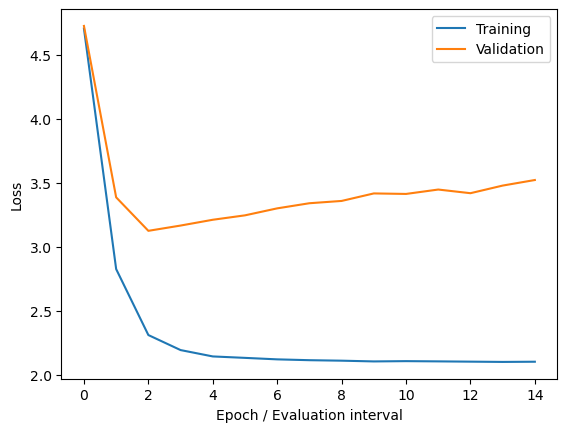

In [19]:
fig = plt.figure()
ax = plt.axes()
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xlabel("Epoch / Evaluation interval")
plt.ylabel("Loss")
plt.legend();

### Run the model to generate text
- What can you say about the quality of the generated text?
- Is it related to the model performance shown in the figure above?

In [20]:
context = torch.zeros((1, N), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))





wobeforey cowe, w is ay Cize airenk obe ul:
arshOn'ts th?
Leauspear hthie us cithe.
bur dXlars, e awece pe.


Wedar t Cim penowhthetof iticcict mit; dillllues iree s, k, w latist ilulvets, anenve pe.
Fie trabuspel lind pe ullliul: oncizey!
Seve aisspll: y; w'lin'l kn fopethigolkinkithis, d moth?


o Wheso whthCitizes toutitoouris anenshireco Cize g r fore

Alk omount f rf sore irist mefld, is aledonthefaf arere g fo utrangouspear, y &y, wardspe this ghesthiuin cct rearaney iry ts chan t ce.
w
